<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Calculate-higher-order-structure-functions" data-toc-modified-id="Calculate-higher-order-structure-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Calculate higher order structure functions</a></span><ul class="toc-item"><li><span><a href="#use-numba-to-speed-up-the-calculation" data-toc-modified-id="use-numba-to-speed-up-the-calculation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>use numba to speed up the calculation</a></span></li><li><span><a href="#Compare-fft-and-2nd-order-sf-on-aircraft-data-from" data-toc-modified-id="Compare-fft-and-2nd-order-sf-on-aircraft-data-from-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Compare fft and 2nd order sf on aircraft data from</a></span></li></ul></li></ul></div>

# Calculate higher order structure functions

In [1]:
from a500.utils.data_read import download
import numpy as np
from matplotlib import pyplot as plt
import os
from numba import jit
#pip install contexttimer
import contexttimer
import time

## use numba to speed up the calculation

In [25]:
@jit(nopython=True)
def calc_sf(vector,num_seps,order=2):
    """
    calculate the nth order structure function
    
    Parameters
    ----------
    
    vector: float32 ndarray
       one-d array of data
       
    num_seps: int
       the number of steps you want to calculate the differences over
       (i.e. num_seps=500 will calculate all differences up to an index separation of 500)
       
    order: int
      order of the structure function
       
    Returns
    -------
    
    (accum, count): (ndarray,ndarry)
        tuple of ndarrays containg the 2nd order structure function
        and the number of data points at each separation
    
    """
    totvals=len(vector)
    accum=totvals
    halfvals = np.int32(totvals/2.)
    spacing = np.arange(1,halfvals,1,np.int32)
    accum= np.zeros(spacing.shape,dtype=np.float32)
    count = np.zeros(spacing.shape,np.int32)
    for accum_index,the_sep in enumerate(spacing[:num_seps]):
        vals=np.arange(the_sep,halfvals,1,np.int32)
        for vec_index in vals:
             accum[accum_index] = accum[accum_index] + \
                (np.abs(vector[vec_index] - vector[vec_index - the_sep]))**order
             count[accum_index] = count[accum_index] + 1
        accum[accum_index] = accum[accum_index]/count[accum_index]
    return accum[:num_seps],count[:num_seps]

## Compare fft and 2nd order sf on aircraft data from 

In [3]:
download('aircraft.npz',root='http://clouds.eos.ubc.ca/~phil/docs/atsc500/data')
data = np.load('aircraft.npz')
wvel = data['wvel']
wvel = wvel - np.mean(wvel)
print(wvel.dtype)
with contexttimer.Timer(time.perf_counter) as pure_wall:
    with contexttimer.Timer(time.process_time) as pure_cpu:
        sf2,count=calc_sf2(wvel,30)   
print(f'pure python wall time {pure_wall.elapsed} and cpu time {pure_cpu.elapsed}')



trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/aircraft.npz
writing to: aircraft.npz

aircraft.npz already exists
and is 732584 bytes
will not overwrite

float32
pure python wall time 0.6152101930347271 and cpu time 0.567069


In [30]:
download('miami_tower.npz',root='http://clouds.eos.ubc.ca/~phil/docs/atsc500/data')
td=np.load('miami_tower.npz') #load temp, uvel, vvel, wvel, minutes
print('keys: ',td.keys())
#print(td['description'])
wvel= td['wvel'].flatten()
wvel = wvel - np.mean(wvel)
wvel=wvel.astype(np.float32)
print(wvel.dtype)
print(wvel.shape)
nvals=500
sf2,count=calc_sf(wvel,nvals,2.) 
sf3,count=calc_sf(wvel,nvals,3.)
sf4,count=calc_sf(wvel,nvals,4.)
sf5,count=calc_sf(wvel,nvals,5.)

trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/miami_tower.npz
writing to: miami_tower.npz

miami_tower.npz already exists
and is 1503441 bytes
will not overwrite

keys:  ['wvel', 'vvel', 'minutes', 'temp', '__header__', 'description', 'uvel', '__globals__', '__version__']
float32
(37501,)


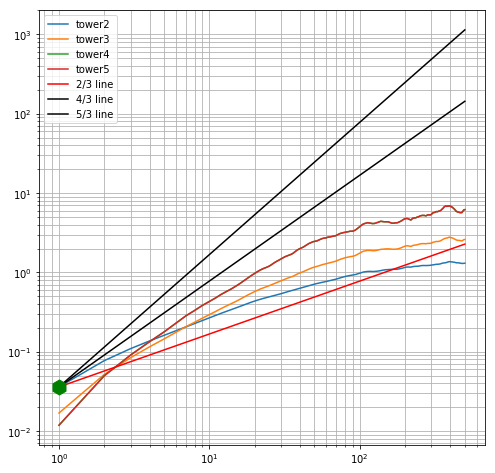

In [31]:
sep_vals=np.arange(1,nvals+1,dtype=np.float)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.loglog(sep_vals,sf2,label='tower2')
ax.loglog(sep_vals,sf3,label='tower3')
ax.loglog(sep_vals,sf4,label='tower4')
ax.loglog(sep_vals,sf4,label='tower5')
leftspec=np.log10(sf2[0])
logy=leftspec + 2./3.*np.log10(sep_vals)
yvals=10.**logy
ax.loglog(sep_vals,yvals,'r-',label='2/3 line')
logy=leftspec + 4./3.*np.log10(sep_vals)
yvals=10.**logy
ax.loglog(sep_vals,yvals,'k-',label='4/3 line')
logy=leftspec + 5./3.*np.log10(sep_vals)
yvals=10.**logy
ax.loglog(sep_vals,yvals,'k-',label='5/3 line')
thePoint=ax.plot(1.,sf2[0],'g+')
thePoint[0].set_markersize(15)
thePoint[0].set_marker('h')
thePoint[0].set_markerfacecolor('g')
ax.grid(True,which='both')
ax.legend()